In [25]:
import pandas as pd
import numpy as np
import pickle as pkl
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/processed/processed_data.csv')
df['timestamp'] = df['bin'] + 288*df['day'] + 31*288*df['month']

In [12]:
df['day'].unique()

array([ 3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25,
       26, 27, 28], dtype=int64)

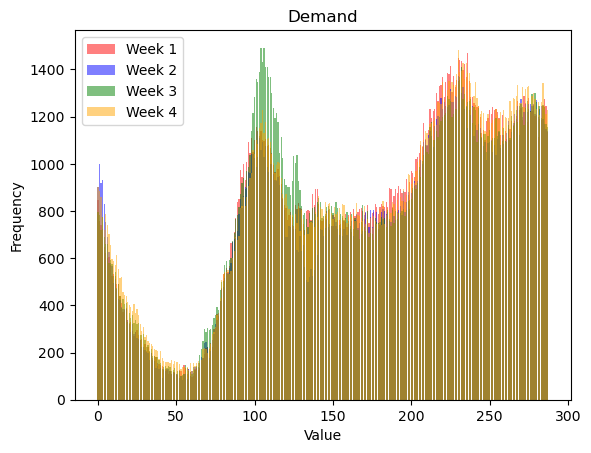

In [27]:
s1 = df.groupby(['day','bin'])['demand'].sum().loc[7]
s2 = df.groupby(['day','bin'])['demand'].sum().loc[14]
s3 = df.groupby(['day','bin'])['demand'].sum().loc[21]
s4 = df.groupby(['day','bin'])['demand'].sum().loc[28]

fig, ax = plt.subplots()

# Plotting the histograms
series_list = [s1, s2, s3, s4]
colors = ['red', 'blue', 'green', 'orange']

for i, series in enumerate(series_list):
    ax.bar(series.index, series.values, alpha=0.5, color=colors[i], label=f'Week {i+1}')

# Adding labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Demand')
ax.legend()

# Display the plot
plt.show()

In [ ]:
df.head()

,zone,bin,day,month,time_period,demand,air_temp,air_temp_feel,rain,snow,residential,education,recreational,commercial,health,subway_stations,bus_stops,avg_demand_five,historical_average,timestamp
0,4,0,3,6,off_peak,7.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,6.052632,54432
1,4,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,4.315789,54433
2,4,2,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,4.473684,54434
3,4,3,3,6,off_peak,3.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,NaN,3.631579,54435
4,4,4,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,57,11,30,0,1,0.0,11.0,3.4,4.631579,54436


In [3]:
zone_id = df['zone'].unique()

### Demand deviation

Process the demand into the deviation from the same time of the previous week.

In [ ]:
def pre_demand(row,df):
    pre_demand = df[(df['bin']==row['bin'])&(df['day']==row['day']-7)]['demand'].values
    if len(pre_demand)==0:
        return None
    else:
        return pre_demand[0]

def demand_diff(df, res):
    
    df['demand_ref'] = df.apply(lambda x:pre_demand(x,df),axis=1)
    res.append(df)

In [ ]:
res = []
_ = df.groupby('zone').apply(lambda df:demand_diff(df,res))

In [ ]:
df_temp = pd.concat(res)
df_temp.head()

,zone,bin,day,month,time_period,demand,air_temp,air_temp_feel,rain,snow,...,education,recreational,commercial,health,subway_stations,bus_stops,avg_demand_five,historical_average,timestamp,demand_ref
0,4,0,3,6,off_peak,7.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,6.052632,54432,NaN
1,4,1,3,6,off_peak,5.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,4.315789,54433,NaN
2,4,2,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,4.473684,54434,NaN
3,4,3,3,6,off_peak,3.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,NaN,3.631579,54435,NaN
4,4,4,3,6,off_peak,1.0,73.18,73.31,0.0,0.0,...,11,30,0,1,0.0,11.0,3.4,4.631579,54436,NaN


In [ ]:
df = df_temp.dropna()
df['demand_diff'] = df['demand'] - df['demand_ref']

C:\Users\11481\AppData\Local\Temp\ipykernel_13200\549742825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['demand_diff'] = df['demand'] - df['demand_ref']


In [ ]:
df.drop(['demand'],axis=1,inplace=True)
df.rename(columns={'demand_diff':'demand'},inplace=True)

C:\Users\11481\AppData\Local\Temp\ipykernel_13200\1108352270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['demand'],axis=1,inplace=True)
C:\Users\11481\AppData\Local\Temp\ipykernel_13200\1108352270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'demand_diff':'demand'},inplace=True)


### Demand

In [29]:
df = df[(df['timestamp']>=61628)] # starting timestamp - 4 ~ ending timestamp
df_demand = df[['zone','month','day','bin','demand','timestamp']]
df_demand = df_demand.sort_values(by=['month','day','bin','zone'])
df_demand.head(10)

,zone,month,day,bin,demand,timestamp
5468,4,6,27,284,7.0,61628
11228,12,6,27,284,0.0,61628
16988,13,6,27,284,12.0,61628
22748,24,6,27,284,4.0,61628
28508,41,6,27,284,14.0,61628
34268,42,6,27,284,15.0,61628
40028,43,6,27,284,1.0,61628
45788,45,6,27,284,6.0,61628
51548,48,6,27,284,48.0,61628
57308,50,6,27,284,15.0,61628


In [30]:
def combine(df_demand,df,x,y,timestamp,included,lookback=2):
    df = df.sort_values('zone')
    time = df['timestamp'].values[0]
    if (time-lookback) in included:
        timestamp.append(time)

        feature_time = [time-i for i in reversed(range(1,lookback+1))]
        pre_demand = df_demand.loc[(df_demand['timestamp'].isin(feature_time))]

        features = pre_demand.groupby(['zone'])['demand'].agg(lambda x:x.tolist()).to_list()
        labels = df['demand'].to_list()
        
        x.append(features)
        y.append(labels)

In [31]:
included = df_demand['timestamp'].unique()
timestamp = []
x = []
y = []
_ = df_demand.groupby('timestamp').apply(lambda df:combine(df_demand,df,x,y,timestamp,included))

In [32]:
x_new = []
y_new = []
timestamp_new = []
for i, time in enumerate(timestamp):
    temp_x = []
    if (time-2) in timestamp:
        temp_x.append(x[i-2])
        temp_x.append(x[i-1])
        x_new.append(temp_x)
        y_new.append(y[i])
        timestamp_new.append(time)

In [33]:
len(x_new)

288

In [34]:
len(y_new)

288

In [35]:
x = np.array(x_new)
y = np.array(y_new)

In [36]:
len(timestamp_new)

288

In [37]:
x.shape

(288, 2, 63, 2)

### History

In [38]:
history = df[['zone','month','day','bin','historical_average','timestamp']]
history = history[history['timestamp'].isin(timestamp_new)]
history = history.sort_values(by=['timestamp','zone'])
history.head()

,zone,month,day,bin,historical_average,timestamp
5472,4,6,28,0,6.052632,61632
11232,12,6,28,0,0.105263,61632
16992,13,6,28,0,5.368421,61632
22752,24,6,28,0,2.421053,61632
28512,41,6,28,0,9.842105,61632


In [39]:
his = np.array(history.groupby('timestamp')['historical_average'].agg(lambda x: x.to_list()).to_list())
# np.save('data/processed/history_diff.npy',his)

### Level of service

In [40]:
los = df[['zone','month','day','bin','subway_stations','bus_stops','timestamp']]
los = los[los['timestamp'].isin(timestamp_new)]
los = los.sort_values(by=['timestamp','zone'])
los['public'] = los['subway_stations'] + 0.2*los['bus_stops']
los.head()

,zone,month,day,bin,subway_stations,bus_stops,timestamp,public
5472,4,6,28,0,0.0,11.0,61632,2.2
11232,12,6,28,0,0.0,0.0,61632,0.0
16992,13,6,28,0,0.0,3.0,61632,0.6
22752,24,6,28,0,1.0,13.0,61632,3.6
28512,41,6,28,0,6.0,36.0,61632,13.2


In [41]:
losn = np.array(los.groupby('timestamp')['public'].agg(lambda x: x.to_list()).to_list())
# np.save('data/processed/los_diff.npy',losn)

### Weather

In [42]:
weather = df[['zone','month','day','bin','air_temp_feel','rain','timestamp']]
weather = weather[weather['timestamp'].isin(timestamp_new)]
weather = weather.sort_values(by=['timestamp','zone'])
weather.head()

,zone,month,day,bin,air_temp_feel,rain,timestamp
5472,4,6,28,0,84.7,0.0,61632
11232,12,6,28,0,84.7,0.0,61632
16992,13,6,28,0,84.7,0.0,61632
22752,24,6,28,0,84.7,0.0,61632
28512,41,6,28,0,84.7,0.0,61632


In [43]:
weather['weather'] = weather.apply(lambda row:[row['air_temp_feel'],row['rain']],axis=1)
wea = np.array(weather.groupby('timestamp')['weather'].agg(lambda x: x.to_list()).to_list())

In [19]:
wea.shape

(284, 63, 2)

In [44]:
np.savez('data/processed/0628.npz',x=x_new,y=y_new,history=his,los=losn,weather=wea)

### Distribution visualization

In [26]:
df['zone'].unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
       236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263], dtype=int64)

<Axes: >

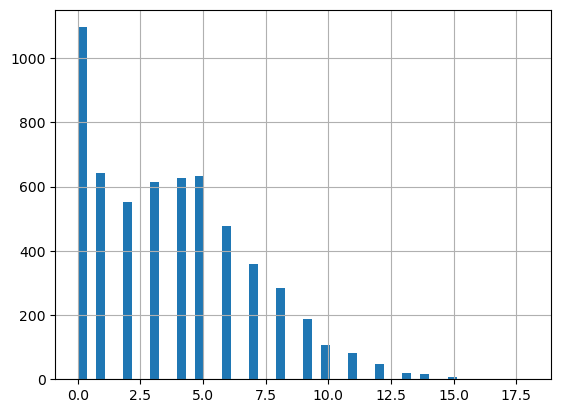

In [38]:
df[df['zone']==43]['demand'].hist(bins=50)